# RNA 3D Folding Data Processing and Modeling Pipeline


This codebase is designed for the processing, analysis, and modeling of RNA 3D folding data. It includes several distinct sections that handle everything from data optimization and loading to model evaluation and submission generation.


## Overview


- **Data Optimization and Loading:**  

  Functions are provided to optimize DataFrame memory usage by downcasting numeric types and converting low-cardinality object columns into categorical types. CSV files containing RNA sequences and labels (3D coordinates) are loaded and concatenated as needed.


- **Data Integrity and Duplicate Checks:**  

  The code performs integrity checks to ensure that data transformations preserve the original information and identifies any duplicate entries.


- **Data Analysis:**  

  Separate routines analyze RNA sequences and 3D coordinates. This includes plotting sequence length distributions and nucleotide frequencies for sequences, as well as coordinate histograms for structural labels.

- **Processed Data Creation:**  

  The pipeline processes sequence and structure data into NumPy arrays (features and targets) suitable for model training and saves these arrays to disk.


- **Structural Variation and TM-Score Calculations:**  

  Functions are implemented to introduce structural variation (by adding controlled noise) and to calculate the TM-score, a metric used to evaluate the similarity between predicted and true RNA structures.


- **Inference and Submission Generation:**  

  A full inference pipeline is provided, including:

  - Creating input JSON files for a given RNA sequence.

  - Running inference using a pre-trained Protenix model.

  - Extracting and processing predictions (including C1' atom coordinates).

  - Generating multi-structure submissions by averaging predictions from several models.


- **Model Search and Evaluation:**  

  The code includes routines to iterate over multiple training configurations in search of the best performing model based on metrics such as MAE, MSE, and TM-score.

## Library Imports 

In [1]:
# Core Python Libraries
import os
import time
import gc
import glob
import json
import sys
import subprocess
import traceback
from collections import Counter
from typing import Optional, Any, Callable
from tqdm import tqdm

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Machine Learning Libraries
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Configuration
warnings = __import__('warnings')  # Import warnings
warnings.filterwarnings('ignore')  # Suppress warnings


## Data Exploration and Analysis

Loading main data files...

Loaded files:
- train_sequences.csv: (844, 5)
- train_labels.csv: (137095, 6)
- validation_sequences.csv: (12, 5)
- validation_labels.csv: (2515, 123)
- test_sequences.csv: (12, 5)
- sample_submission.csv: (2515, 18)

===== Training Sequences Analysis =====
Total sequences: 844
Columns available: ['target_id', 'sequence', 'temporal_cutoff', 'description', 'all_sequences']


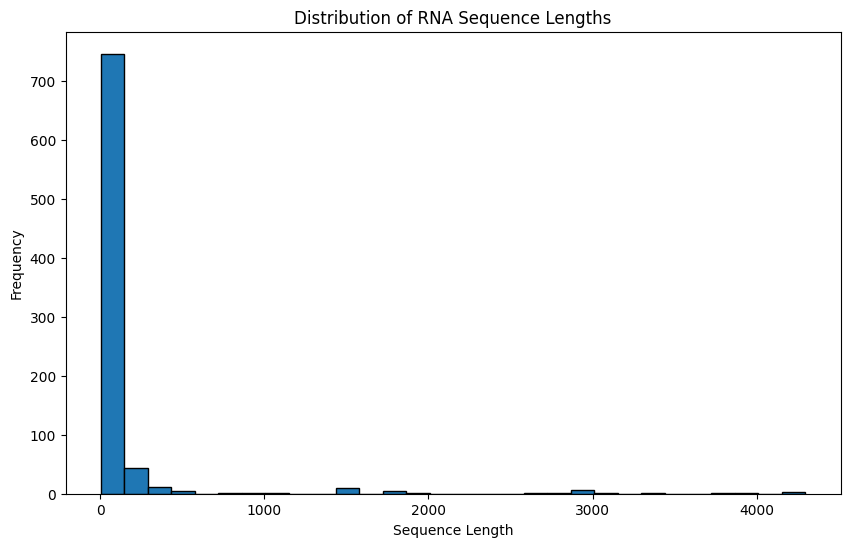

Sequence length statistics:
Min: 3, Max: 4298, Average: 162.43

Nucleotide distribution:
A: 32524 (23.72%)
C: 33937 (24.76%)
G: 41450 (30.24%)
U: 29178 (21.28%)

===== Training Labels Analysis =====
Total label entries: 137095
Columns available: ['ID', 'resname', 'resid', 'x_1', 'y_1', 'z_1']

Found 3 coordinate columns.


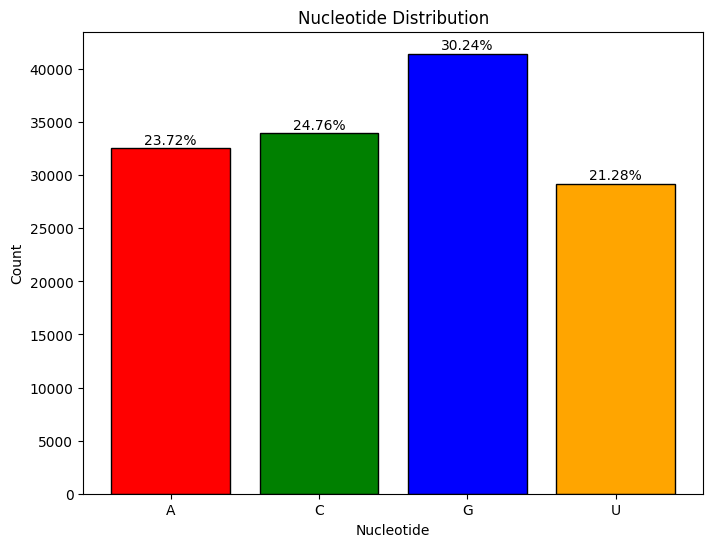

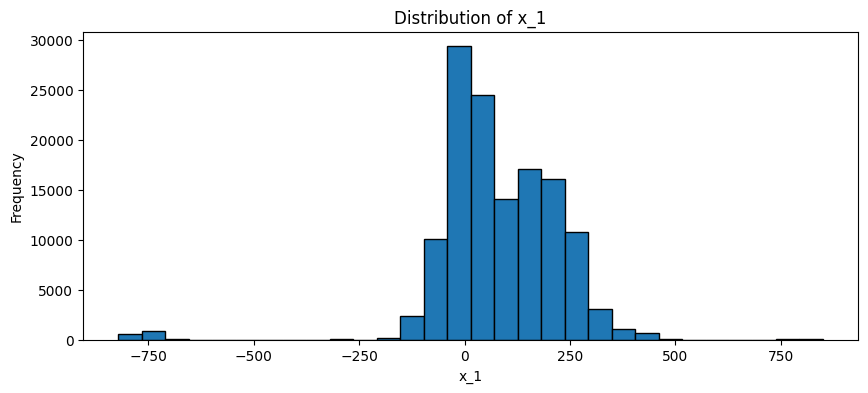

x_1 - Mean: 80.45, Std: 147.42


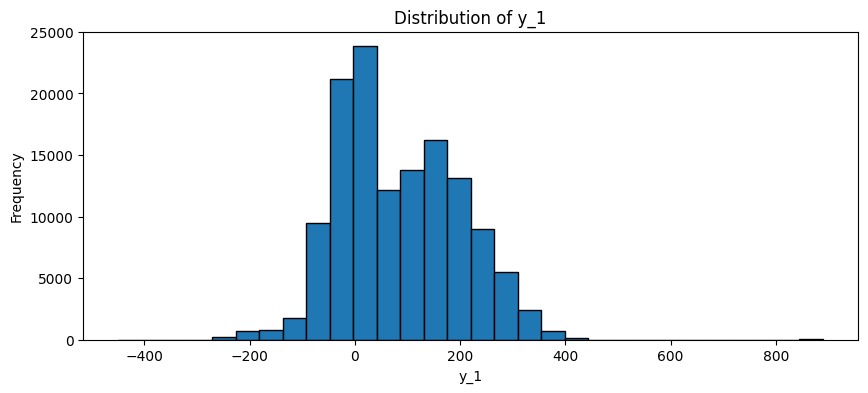

y_1 - Mean: 84.04, Std: 114.93


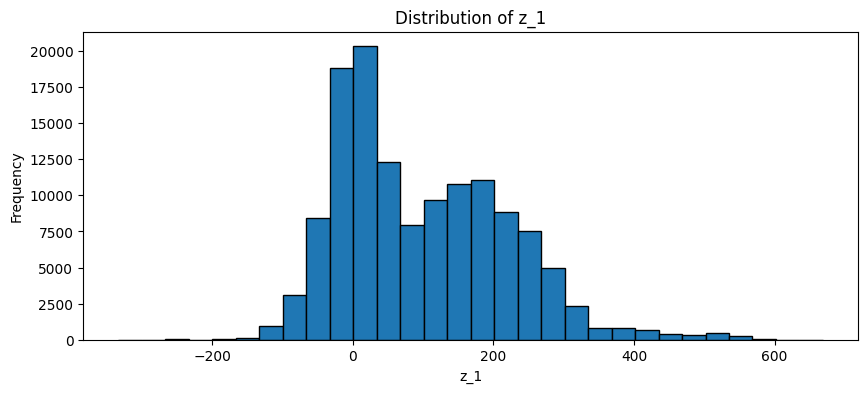

z_1 - Mean: 98.61, Std: 119.41

Checking duplicates in training sequences...
No duplicates found.

Creating submission template...
Submission template created based on the provided sample submission.
Submission template shape: (2515, 18)
        ID resname  resid  x_1  y_1  z_1  x_2  y_2  z_2  x_3  y_3  z_3  x_4  \
0  R1107_1       G      1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  R1107_2       G      2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  R1107_3       G      3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  R1107_4       G      4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  R1107_5       G      5  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   y_4  z_4  x_5  y_5  z_5  
0  0.0  0.0  0.0  0.0  0.0  
1  0.0  0.0  0.0  0.0  0.0  
2  0.0  0.0  0.0  0.0  0.0  
3  0.0  0.0  0.0  0.0  0.0  
4  0.0  0.0  0.0  0.0  0.0  

Runtime: 1.56 seconds


In [2]:
# Define constants and file paths
DATA_DIR: str = os.getenv('DATA_DIR', '/kaggle/input/stanford-rna-3d-folding/')
MAIN_FILES: list[str] = [
    "train_sequences.csv", 
    "train_labels.csv", 
    "validation_sequences.csv", 
    "validation_labels.csv", 
    "test_sequences.csv",
    "sample_submission.csv"
]
DEFAULT_THRESHOLD: float = 0.4  # Default threshold for category conversion

# -------------------------
# Data Optimization Section
# -------------------------
def optimize_dataframe(
    df: pd.DataFrame, 
    inplace: bool = False, 
    category_threshold: float = DEFAULT_THRESHOLD
) -> pd.DataFrame:
    """
    Optimizes the DataFrame to save memory by downcasting numeric types and
    converting low-cardinality object columns to 'category'.
    """
    if not 0 <= category_threshold <= 1:
        raise ValueError("category_threshold must be between 0 and 1.")
    
    df = df if inplace else df.copy()
    
    for col in df.columns:
        col_type = df[col].dtype
        
        # Optimize integer columns
        if np.issubdtype(col_type, np.integer):
            c_min, c_max = df[col].min(), df[col].max()
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        # Optimize floating point columns
        elif np.issubdtype(col_type, np.floating):
            if df[col].min() > np.finfo(np.float32).min and df[col].max() < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
        
        # Convert object columns to category if low cardinality
        elif col_type == object:
            unique_vals = len(df[col].unique())
            if unique_vals / len(df) < category_threshold:
                df[col] = df[col].astype('category')
    
    return df

# -------------------------
# Data Loading Section
# -------------------------
def load_main_data(chunksize: int = 50000) -> dict[str, pd.DataFrame]:
    """
    Loads CSV files from the main files list, optimizes them, and returns a dictionary
    mapping file names to their respective DataFrames.
    """
    data: dict[str, pd.DataFrame] = {}
    for file_name in MAIN_FILES:
        file_path: str = os.path.join(DATA_DIR, file_name)
        if os.path.exists(file_path):
            chunks = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False, chunksize=chunksize)
            dataframes = [optimize_dataframe(chunk, category_threshold=DEFAULT_THRESHOLD) for chunk in chunks]
            data[file_name] = pd.concat(dataframes, ignore_index=True)
        else:
            print(f"File {file_path} not found!")
    return data

# -------------------------
# Data Integrity and Duplicate Checks
# -------------------------
def check_data_integrity(original_df: pd.DataFrame, optimized_df: pd.DataFrame) -> None:
    """
    Checks whether the optimization has preserved the original data.
    """
    try:
        pd.testing.assert_frame_equal(original_df, optimized_df, check_like=True)
        print("Integrity check passed: Data is unchanged after optimization.")
    except AssertionError as error:
        print(f"Data integrity check failed: {error}")

def check_duplicates(df: pd.DataFrame) -> Optional[pd.DataFrame]:
    """
    Checks and returns duplicate entries in the DataFrame.
    """
    duplicates: pd.DataFrame = df[df.duplicated(keep=False)]
    if not duplicates.empty:
        print(f"Warning: Found {duplicates.shape[0]} duplicate entries.")
        return duplicates
    else:
        print("No duplicates found.")
    return None

# -------------------------
# Threshold Testing and Plotting
# -------------------------
def test_thresholds(df: pd.DataFrame) -> tuple[np.ndarray, list[float]]:
    """
    Tests different thresholds for converting object columns to categories
    and returns the thresholds and their corresponding memory usages.
    """
    thresholds: np.ndarray = np.linspace(0.1, 0.9, 9)
    memory_usages: list[float] = []
    for threshold in thresholds:
        optimized_df = optimize_dataframe(df.copy(), category_threshold=threshold)
        mem_usage = optimized_df.memory_usage(deep=True).sum() / 1024**2
        memory_usages.append(mem_usage)
    return thresholds, memory_usages

def plot_memory_usage(thresholds: np.ndarray, memory_usages: list[float]) -> None:
    """
    Plots memory usage against the threshold values.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, memory_usages, marker='o', linestyle='-')
    plt.title("Memory Usage vs. Threshold")
    plt.xlabel("Threshold")
    plt.ylabel("Memory Usage (MB)")
    plt.grid(True)
    plt.show()

# -------------------------
# Data Analysis Section
# -------------------------
def analyze_sequence_data(df_sequences: pd.DataFrame) -> None:
    """
    Analyzes RNA sequence data and plots a histogram of sequence lengths.
    """
    print(f"Total sequences: {len(df_sequences)}")
    print(f"Columns available: {df_sequences.columns.tolist()}")
    
    if 'sequence' in df_sequences.columns:
        seq_lengths = df_sequences['sequence'].apply(len)
        
        # Plot histogram of sequence lengths
        plt.figure(figsize=(10, 6))
        plt.hist(seq_lengths, bins=30, edgecolor='black')
        plt.title("Distribution of RNA Sequence Lengths")
        plt.xlabel("Sequence Length")
        plt.ylabel("Frequency")
        plt.show()
        
        print(f"Sequence length statistics:\nMin: {seq_lengths.min()}, Max: {seq_lengths.max()}, Average: {seq_lengths.mean():.2f}")
        
        # Nucleotide count analysis
        nucleotides = ['A', 'C', 'G', 'U']
        nucleotide_counts = {n: df_sequences['sequence'].str.count(n).sum() for n in nucleotides}
        total_nucleotides = sum(nucleotide_counts.values())
        
        print("\nNucleotide distribution:")
        for nucleotide, count in nucleotide_counts.items():
            print(f"{nucleotide}: {count} ({(count / total_nucleotides * 100):.2f}%)")
        plot_nucleotide_distribution(df_sequences)

def plot_nucleotide_distribution(df_sequences: pd.DataFrame) -> None:
    """
    Plots the nucleotide distribution as a bar chart showing counts and percentages
    with different colors for each nucleotide.
    """
    nucleotides = ['A', 'C', 'G', 'U']
    nucleotide_counts = {n: df_sequences['sequence'].str.count(n).sum() for n in nucleotides}
    total_nucleotides = sum(nucleotide_counts.values())
    
    # Prepare data for plotting
    labels = list(nucleotide_counts.keys())
    counts = list(nucleotide_counts.values())
    percentages = [count / total_nucleotides * 100 for count in counts]
    
    # Define different colors for each bar
    colors = ['red', 'green', 'blue', 'orange']
    
    # Create bar chart with different colors
    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, counts, color=colors, edgecolor='black')
    plt.xlabel("Nucleotide")
    plt.ylabel("Count")
    plt.title("Nucleotide Distribution")
    
    # Annotate each bar with its percentage
    for bar, percentage in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.001 * total_nucleotides, f"{percentage:.2f}%", ha='center', va='bottom')


def analyze_label_data(df_labels: pd.DataFrame) -> None:
    """
    Analyzes 3D coordinate data in the labels DataFrame and plots histograms for each coordinate.
    """
    print(f"Total label entries: {len(df_labels)}")
    print(f"Columns available: {df_labels.columns.tolist()}")
    
    coord_columns = [col for col in df_labels.columns if col.startswith(('x_', 'y_', 'z_'))]
    if coord_columns:
        print(f"\nFound {len(coord_columns)} coordinate columns.")
        # Plot histograms for each coordinate column
        for col in coord_columns:
            plt.figure(figsize=(10, 4))
            plt.hist(df_labels[col].dropna(), bins=30, edgecolor='black')
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()
            
            print(f"{col} - Mean: {df_labels[col].mean():.2f}, Std: {df_labels[col].std():.2f}")

# -------------------------
# Submission Template Creation
# -------------------------
def create_submission_template(
    test_df: pd.DataFrame, 
    sample_submission_df: Optional[pd.DataFrame]
) -> pd.DataFrame:
    """
    Creates a submission template. If a sample submission is provided, it copies it;
    otherwise, it generates a new template based on the test sequences.
    """
    if sample_submission_df is None:
        print("Sample submission file not found. Generating a new submission template.")
        ids, resnames, resids = [], [], []
        
        for _, row in test_df.iterrows():
            sequence = row.get('sequence')
            target_id = row.get('target_id')
            if sequence and target_id:
                for i, nucleotide in enumerate(sequence, start=1):
                    ids.append(f"{target_id}_{i}")
                    resnames.append(nucleotide)
                    resids.append(i)
        
        submission_df = pd.DataFrame({
            'ID': ids,
            'resname': resnames,
            'resid': resids
        })
        
        # Initialize coordinate columns for five structures
        for i in range(1, 6):
            submission_df[f'x_{i}'] = 0.0
            submission_df[f'y_{i}'] = 0.0
            submission_df[f'z_{i}'] = 0.0
    else:
        submission_df = sample_submission_df.copy()
        print("Submission template created based on the provided sample submission.")
    
    return submission_df

# -------------------------
# Main Routine
# -------------------------
def main() -> dict[str, pd.DataFrame]:
    start_time = time.time()
    
    print("Loading main data files...")
    data: dict[str, pd.DataFrame] = load_main_data()
    
    # Report loaded file shapes
    print("\nLoaded files:")
    for file_name, df in data.items():
        shape_info = df.shape if df is not None else "Not found"
        print(f"- {file_name}: {shape_info}")
    
    # Analyze training sequences
    if "train_sequences.csv" in data:
        print("\n===== Training Sequences Analysis =====")
        analyze_sequence_data(data["train_sequences.csv"])
    
    # Analyze training labels
    if "train_labels.csv" in data:
        print("\n===== Training Labels Analysis =====")
        analyze_label_data(data["train_labels.csv"])
    
    # Check for duplicates in training sequences
    if "train_sequences.csv" in data:
        print("\nChecking duplicates in training sequences...")
        check_duplicates(data["train_sequences.csv"])
    
    
    # Create submission template
    if "test_sequences.csv" in data:
        print("\nCreating submission template...")
        submission_df = create_submission_template(
            test_df=data["test_sequences.csv"],
            sample_submission_df=data.get("sample_submission.csv")
        )
        print(f"Submission template shape: {submission_df.shape}")
        print(submission_df.head())
    
    runtime = time.time() - start_time
    print(f"\nRuntime: {runtime:.2f} seconds")
    
    return data

if __name__ == '__main__':
    main_data = main()


## Data Preperation

In [3]:
# File paths
DATA_DIR: str = "/kaggle/input/stanford-rna-3d-folding/"
OUTPUT_DIR: str = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

def load_data() -> dict[str, pd.DataFrame]:
    """
    Loads the necessary CSV files for the competition.
    
    Returns:
        A dictionary containing DataFrames for:
          - train_seq: training sequences
          - valid_seq: validation sequences
          - test_seq: test sequences
          - train_labels: training structures (3D coordinates)
          - valid_labels: validation structures (3D coordinates)
          - sample_submission: sample submission format
    """
    data: dict[str, pd.DataFrame] = {}
    data['train_seq'] = pd.read_csv(os.path.join(DATA_DIR, "train_sequences.csv"))
    data['valid_seq'] = pd.read_csv(os.path.join(DATA_DIR, "validation_sequences.csv"))
    data['test_seq'] = pd.read_csv(os.path.join(DATA_DIR, "test_sequences.csv"))
    data['train_labels'] = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
    data['valid_labels'] = pd.read_csv(os.path.join(DATA_DIR, "validation_labels.csv"))
    data['sample_submission'] = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
    
    return data

def create_mapping_valid(valid_seq_df: pd.DataFrame, valid_labels_df: pd.DataFrame) -> dict[str, dict[str, Any]]:
    """
    Creates a mapping between validation sequences and their corresponding 3D structures.
    
    Args:
        valid_seq_df: DataFrame with validation sequences.
        valid_labels_df: DataFrame with validation labels (3D coordinates).
        
    Returns:
        A dictionary where each key is a sequence ID and the value is a dictionary with:
          - 'sequence': The RNA sequence.
          - 'structures': A list of structures (each is a list of [x, y, z] coordinates).
    """
    # Extract sequence ID from label ID (format: e.g., "R1107_1" -> "R1107")
    valid_labels_df['seq_id'] = valid_labels_df['ID'].apply(lambda x: x.split('_')[0])
    
    seq_ids: set = set(valid_seq_df['target_id'])
    label_seq_ids: set = set(valid_labels_df['seq_id'])
    
    overlap: set = seq_ids.intersection(label_seq_ids)
    print(f"Correspondence for validation: {len(overlap)} of {len(seq_ids)}")
    
    mapping: dict[str, dict[str, Any]] = {}
    for seq_id in overlap:
        # Retrieves the sequence
        seq: str = valid_seq_df[valid_seq_df['target_id'] == seq_id]['sequence'].iloc[0]
    
        # Get all residues for this sequence, sorted by residue number
        residues: pd.DataFrame = valid_labels_df[valid_labels_df['seq_id'] == seq_id].sort_values('resid')
        
        # Determine the number of structures from coordinate columns (x_i)
        num_structures: int = 1
        for col in residues.columns:
            if col.startswith('x_'):
                struct_num = int(col.split('_')[1])
                num_structures = max(num_structures, struct_num)
        
        structures: list[list[list[float]]] = []
        
        # Build a structure for each available prediction
        for struct_idx in range(1, num_structures + 1):
            coords: list[list[float]] = []
            has_valid_coords: bool = False
            if f'x_{struct_idx}' in residues.columns:
                for _, row in residues.iterrows():
                    x: float = row[f'x_{struct_idx}']
                    y: float = row[f'y_{struct_idx}']
                    z: float = row[f'z_{struct_idx}']
                    # Validate coordinate values
                    if abs(x) < 1.0e+17 and abs(y) < 1.0e+17 and abs(z) < 1.0e+17:
                        coords.append([x, y, z])
                        has_valid_coords = True
                    else:
                        coords.append([np.nan, np.nan, np.nan])
            if has_valid_coords:
                structures.append(coords)
        
        if structures:
            mapping[seq_id] = {
                'sequence': seq,
                'structures': structures
            }
    
    print(f"Mapping created with {len(mapping)} valid sequences")
    return mapping

def create_processed_data(mapping: dict[str, dict[str, Any]], output_prefix: str) -> tuple[Optional[np.ndarray], Optional[np.ndarray], list[str]]:
    """
    Processes the mapping to create feature (X) and target (y) arrays suitable for training.
    It also saves these arrays to the output directory.
    
    Args:
        mapping: Dictionary with mapping of sequences to structures.
        output_prefix: A prefix for naming output files (e.g., 'train' or 'valid').
        
    Returns:
        A tuple (X, y, ids) where:
            X: A NumPy array of one-hot encoded sequences.
            y: A NumPy array of coordinate targets.
            ids: List of sequence IDs.
    """
    if not mapping:
        print(f"WARNING: No valid mapping for {output_prefix}")
        return None, None, []
    
    X_data: list[np.ndarray] = []
    y_data: list[np.ndarray] = []
    ids: list[str] = []
    
    for seq_id, data in mapping.items():
        seq: str = data['sequence']
        structures: list[list[list[float]]] = data['structures']
        if not structures:
            continue
        
        # Use the first valid structure for training
        structure: list[list[float]] = structures[0]
        if len(structure) != len(seq):
            print(f"WARNING: Sequence length ({len(seq)}) and coordinate count ({len(structure)}) differ for {seq_id}")
            continue
        
        # One-hot encoding for the sequence (A, C, G, U, unknown)
        features: list[list[int]] = []
        for nucleotide in seq:
            if nucleotide == 'A':
                features.append([1, 0, 0, 0, 0])
            elif nucleotide == 'C':
                features.append([0, 1, 0, 0, 0])
            elif nucleotide == 'G':
                features.append([0, 0, 1, 0, 0])
            elif nucleotide == 'U':
                features.append([0, 0, 0, 1, 0])
            else:
                features.append([0, 0, 0, 0, 1])
        
        X_data.append(np.array(features))
        y_data.append(np.array(structure))
        ids.append(seq_id)
    
    if not X_data:
        print(f"WARNING: No valid processed data for {output_prefix}")
        return None, None, []
    
    # Pad sequences so all examples have the same length
    max_length: int = max(x.shape[0] for x in X_data)
    X_padded: list[np.ndarray] = []
    y_padded: list[np.ndarray] = []
    
    for x, y in zip(X_data, y_data):
        if x.shape[0] < max_length:
            x_pad = np.zeros((max_length, 5))
            x_pad[:x.shape[0], :] = x
            y_pad = np.zeros((max_length, 3))
            y_pad[:y.shape[0], :] = y
            X_padded.append(x_pad)
            y_padded.append(y_pad)
        else:
            X_padded.append(x)
            y_padded.append(y)
    
    X: np.ndarray = np.array(X_padded)
    y: np.ndarray = np.array(y_padded)
    
    # Save processed arrays
    np.save(os.path.join(OUTPUT_DIR, f'X_{output_prefix}.npy'), X)
    np.save(os.path.join(OUTPUT_DIR, f'y_{output_prefix}.npy'), y)
    with open(os.path.join(OUTPUT_DIR, f'{output_prefix}_ids.txt'), 'w') as f:
        for id_val in ids:
            f.write(f"{id_val}\n")
    
    print(f"Processed data for {output_prefix}: X.shape = {X.shape}, y.shape = {y.shape}")
    return X, y, ids

def main() -> dict[str, Any]:
    """
    Main routine for loading data, creating a mapping for validation sequences,
    processing the data into features and targets, and saving the processed data.
    
    Returns:
        A dictionary containing processed data arrays and mapping details.
    """
    print("Loading data...")
    data_dict: dict[str, pd.DataFrame] = load_data()
    
    print("\nCreating mapping for validation data...")
    valid_mapping: dict[str, dict[str, Any]] = create_mapping_valid(data_dict['valid_seq'], data_dict['valid_labels'])
    
    # Process and save validation data
    X_valid, y_valid, valid_ids = create_processed_data(valid_mapping, 'valid')
    
    # In absence of a reliable training mapping, we use validation data for training
    print("\nUsing validation data as training (due to mapping constraints)...")
    X_train, y_train, train_ids = X_valid, y_valid, valid_ids
    if X_train is not None:
        np.save(os.path.join(OUTPUT_DIR, 'X_train.npy'), X_train)
        np.save(os.path.join(OUTPUT_DIR, 'y_train.npy'), y_train)
        with open(os.path.join(OUTPUT_DIR, 'train_ids.txt'), 'w') as f:
            for id_val in train_ids:
                f.write(f"{id_val}\n")
    
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_valid': X_valid,
        'y_valid': y_valid,
        'valid_mapping': valid_mapping,
        'valid_ids': valid_ids
    }

if __name__ == "__main__":
    processed_data = main()


Loading data...

Creating mapping for validation data...
Correspondence for validation: 12 of 12
Mapping created with 12 valid sequences
Processed data for valid: X.shape = (12, 720, 5), y.shape = (12, 720, 3)

Using validation data as training (due to mapping constraints)...


## RNA 3D Folding Pipeline

In [4]:
# Define directories
DATA_DIR = "/kaggle/input/stanford-rna-3d-folding/"
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

##############################################
# 1. Function to generate structural variation
##############################################
def sample_structural_variation(coords, noise_level=0.5, preserve_distance=True, 
                                use_global_movement=False, correlation=0.7):
    """
    Enhanced version of structural variation sampling with better
    handling of large RNAs and improved noise distribution.
    """
    new_coords = coords.copy()
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_indices = np.where(valid_mask)[0]
    
    if len(valid_indices) < 3:
        return new_coords
    
    typical_bond_length = 3.8  # Typical RNA backbone distance
    
    if use_global_movement and len(valid_indices) > 20:
        distances = []
        for i in range(1, len(valid_indices)):
            idx1 = valid_indices[i-1]
            idx2 = valid_indices[i]
            dist = np.linalg.norm(coords[idx1] - coords[idx2])
            distances.append((i, dist))
        distances.sort(key=lambda x: x[1], reverse=True)
        num_hinges = min(2, len(distances)//3)
        for h in range(num_hinges):
            if h < len(distances):
                hinge_point = distances[h][0]
                if hinge_point < 5 or hinge_point > len(valid_indices) - 5:
                    continue
                hinge_idx = valid_indices[hinge_point]
                angle = np.random.exponential(0.2)
                if np.random.random() < 0.5:
                    angle = -angle
                sin_a, cos_a = np.sin(angle), np.cos(angle)
                tilt = np.random.normal(0, 0.1)
                rotation_matrix = np.array([
                    [cos_a, -sin_a, 0],
                    [sin_a, cos_a, tilt],
                    [0, -tilt, 1]
                ])
                ref_point = new_coords[hinge_idx]
                for i in valid_indices[hinge_point+1:]:
                    vector = new_coords[i] - ref_point
                    rotated = np.dot(vector, rotation_matrix)
                    new_coords[i] = ref_point + rotated
    
    prev_noise = np.zeros(3)
    correlation = 0.5  # High correlation for smoother variations
    for i in range(1, len(coords)):
        if not valid_mask[i] or not valid_mask[i-1]:
            continue
        vec = new_coords[i-1] - new_coords[i]
        vec_length = np.linalg.norm(vec)
        new_noise = np.random.normal(0, noise_level, size=3)
        noise_vec = correlation * prev_noise + (1 - correlation) * new_noise
        prev_noise = noise_vec.copy()
        noise_norm = np.linalg.norm(noise_vec)
        if noise_norm > 0:
            noise_vec = noise_vec / noise_norm * (noise_level * vec_length)
        new_vec = vec + noise_vec
        if preserve_distance:
            current_length = np.linalg.norm(new_vec)
            if current_length > 0:
                target_length = typical_bond_length * (1 + np.random.normal(0, 0.05))
                new_vec = new_vec / current_length * target_length
        new_coords[i] = new_coords[i-1] - new_vec
    
    return new_coords

def normalize_structure(coords):
    """
    Centralizes and normalizes the structure.
    """
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_coords = coords[valid_mask]
    center = np.mean(valid_coords, axis=0)
    centered_coords = coords.copy()
    centered_coords[valid_mask] = valid_coords - center
    return centered_coords

def check_structure_validity(coords, min_distance=0.8, max_distance=7.0, allow_clashes=0.05):
    """
    Checks the structure for bond validity and residue clashes.
    """
    valid = True
    valid_mask = ~np.all(coords == 0, axis=1)
    valid_coords = coords[valid_mask]
    
    if len(valid_coords) < 3:
        return True
    
    invalid_bonds = 0
    for i in range(1, len(valid_coords)):
        dist = np.linalg.norm(valid_coords[i] - valid_coords[i-1])
        if dist < min_distance or dist > max_distance:
            invalid_bonds += 1
    if invalid_bonds / len(valid_coords) > 0.1:
        valid = False
    
    clashes = 0
    total_pairs = 0
    for i in range(len(valid_coords)):
        for j in range(i+3, len(valid_coords)):
            total_pairs += 1
            dist = np.linalg.norm(valid_coords[i] - valid_coords[j])
            if dist < min_distance:
                clashes += 1
    if total_pairs > 0 and clashes / total_pairs > allow_clashes:
        valid = False
    
    return valid

##############################################
# 2. TM-score Calculation Functions
##############################################
def calculate_tm_score(pred_coords, true_coords, d0_scale=1.24):
    """
    Calculates an approximate TM-score between predicted and true coordinates.
    """
    mask = ~np.all(true_coords == 0, axis=1)
    pred = pred_coords[mask]
    true = true_coords[mask]
    L = len(true)
    if L < 3:
        return 0.0
    if L >= 30:
        d0 = 0.6 * np.sqrt(L - 0.5) - 2.5
        d0 = max(0.1, d0)
    elif L >= 24:
        d0 = 0.7
    elif L >= 20:
        d0 = 0.6
    elif L >= 16:
        d0 = 0.5
    elif L >= 12:
        d0 = 0.4
    else:
        d0 = 0.3
    distances = np.sqrt(np.sum((pred - true) ** 2, axis=1))
    tm_terms = 1.0 / (1.0 + (distances / (d0 + 1e-8)) ** 2)
    tm_score = np.sum(tm_terms) / L
    return float(tm_score)

def calculate_tm_score_exact(pred_coords, true_coords):
    """
    Calculates TM-score with multiple rotation schemes.
    """
    mask = ~np.all(true_coords == 0, axis=1)
    pred = pred_coords[mask]
    true = true_coords[mask]
    Lref = len(true)
    if Lref < 3:
        return 0.0
    if Lref >= 30:
        d0 = 0.6 * np.sqrt(Lref - 0.5) - 2.5
    elif Lref >= 24:
        d0 = 0.7
    elif Lref >= 20:
        d0 = 0.6
    elif Lref >= 16:
        d0 = 0.5
    elif Lref >= 12:
        d0 = 0.4
    else:
        d0 = 0.3
    pred_centered = pred - np.mean(pred, axis=0)
    true_centered = true - np.mean(true, axis=0)
    best_tm_score = 0.0
    fragment_lengths = [Lref, max(5, Lref//2), max(5, Lref//4)]
    for frag_len in fragment_lengths:
        for i in range(0, Lref - frag_len + 1, max(1, frag_len//2)):
            pred_frag = pred_centered[i:i+frag_len]
            for j in range(0, Lref - frag_len + 1, max(1, frag_len//2)):
                true_frag = true_centered[j:j+frag_len]
                covariance = np.dot(pred_frag.T, true_frag)
                U, S, Vt = np.linalg.svd(covariance)
                rotation = np.dot(U, Vt)
                rotations_to_try = [
                    rotation,
                    np.dot(rotation, np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])),
                    np.dot(rotation, np.array([[-1, 0, 0], [0, -1, 0], [0, 0, 1]]))
                ]
                for rot in rotations_to_try:
                    pred_aligned = np.dot(pred_centered, rot)
                    distances = np.sqrt(np.sum((pred_aligned - true_centered) ** 2, axis=1))
                    tm_terms = 1.0 / (1.0 + (distances / d0) ** 2)
                    tm_score = np.sum(tm_terms) / Lref
                    best_tm_score = max(best_tm_score, tm_score)
    return float(best_tm_score)

##############################################
# 3. Data Loading Function
##############################################
def load_processed_data():
    """
    Loads processed training and validation data.
    """
    X_train = np.load(os.path.join(OUTPUT_DIR, 'X_train.npy'))
    y_train = np.load(os.path.join(OUTPUT_DIR, 'y_train.npy'))
    X_valid = np.load(os.path.join(OUTPUT_DIR, 'X_valid.npy'))
    y_valid = np.load(os.path.join(OUTPUT_DIR, 'y_valid.npy'))
    
    print(f"Data loaded - X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Data loaded - X_valid: {X_valid.shape}, y_valid: {y_valid.shape}")
    
    return X_train, y_train, X_valid, y_valid

##############################################
# 4. Reference Model (Baseline)
##############################################
def reference_based_approach(X_ref, y_ref, geometric_sampling=False, noise_level=0.2, correlation=0.7):
    try:
        class ReferenceModel:
            def __init__(self, geometric_sampling=False, base_noise_level=0.2, correlation=0.7):
                self.geometric_sampling = geometric_sampling
                self.base_noise_level = base_noise_level
                self.correlation = correlation
                
            def fit(self, X, y):
                self.reference_structures = np.nan_to_num(y, nan=0.0)
                self.global_mean = np.nanmean(y, axis=(0, 1))
                self.global_std = np.nanstd(y, axis=(0, 1))
                self.global_mean = np.nan_to_num(self.global_mean, nan=0.0)
                self.global_std = np.nan_to_num(self.global_std, nan=1.0)
                self.size_groups = {}
                for i in range(len(self.reference_structures)):
                    valid_mask = ~np.all(self.reference_structures[i] == 0, axis=1)
                    size = np.sum(valid_mask)
                    if size < 120:
                        group = "small"
                    elif size < 200:
                        group = "medium"
                    else:
                        group = "large"
                    if group not in self.size_groups:
                        self.size_groups[group] = []
                    self.size_groups[group].append(i)
                print(f"Size distribution - Small: {len(self.size_groups.get('small', []))}, "
                      f"Medium: {len(self.size_groups.get('medium', []))}, "
                      f"Large: {len(self.size_groups.get('large', []))}")
                return self
                
            def predict(self, X):
                batch_size = X.shape[0]
                seq_length = X.shape[1]
                predictions = np.zeros((batch_size, seq_length, 3))
                for i in range(batch_size):
                    valid_mask = ~np.all(X[i] == 0, axis=1)
                    size = np.sum(valid_mask)
                    if size < 120:
                        noise_level = self.base_noise_level * 0.6
                    elif size < 200:
                        noise_level = self.base_noise_level * 1.0
                    else:
                        noise_level = self.base_noise_level * 0.4
                    group = "small" if size < 120 else "medium" if size < 200 else "large"
                    if group in self.size_groups:
                        ref_idx = np.random.choice(self.size_groups[group])
                        base_struct = self.reference_structures[ref_idx].copy()
                        if self.geometric_sampling:
                            predictions[i] = sample_structural_variation(
                                base_struct, 
                                noise_level=noise_level,
                                preserve_distance=True,
                                use_global_movement=(size < 120),
                                correlation=self.correlation
                            )
                        else:
                            noise = np.random.normal(0, noise_level, base_struct.shape)
                            predictions[i] = base_struct + noise
                    else:
                        sample = np.random.normal(self.global_mean, self.global_std, size=(seq_length, 3))
                        if self.geometric_sampling:
                            predictions[i] = sample_structural_variation(
                                sample, 
                                noise_level=noise_level,
                                preserve_distance=True,
                                use_global_movement=(size < 120),
                                correlation=self.correlation
                            )
                        else:
                            predictions[i] = sample
                return predictions
        
        model = ReferenceModel(geometric_sampling=geometric_sampling, 
                               base_noise_level=noise_level,
                               correlation=correlation)
        model.fit(X_ref, y_ref)
        return model
    
    except Exception as e:
        print(f"Error in reference_based_approach: {str(e)}")
        return None

##############################################
# 5. Model Evaluation Function
##############################################
def evaluate_model(model, X_valid, y_valid):
    """
    Evaluates the model by calculating MAE, MSE, and TM-score for each structure.
    """
    y_valid = np.nan_to_num(y_valid, nan=0.0)
    y_pred = model.predict(X_valid)
    y_pred = np.nan_to_num(y_pred, nan=0.0)
    mae = np.mean(np.abs(y_pred - y_valid))
    mse = np.mean((y_pred - y_valid)**2)
    print(f"Overall MAE: {mae:.4f}")
    print(f"Overall MSE: {mse:.4f}")
    tm_scores = []
    for i in range(len(X_valid)):
        tm = calculate_tm_score(y_pred[i], y_valid[i])
        tm_scores.append(tm)
    avg_tm_score = np.mean(tm_scores)
    print(f"Average approximate TM-score: {avg_tm_score:.4f}")
    return {
        'mae': mae,
        'mse': mse,
        'tm_scores': tm_scores,
        'avg_tm_score': avg_tm_score
    }

##############################################
# 6. Main Function to Search for the Best Model
##############################################
def search_best_model(X_train, y_train, X_valid, y_valid, max_iterations=10, target_score=0.20):
    """
    Searches for the best performing model over multiple iterations.
    """
    best_model = None
    best_metrics = None
    best_score = 0.0
    print(f"Starting model search (max {max_iterations} iterations, target score: {target_score})")
    for iteration in range(max_iterations):
        print(f"\n----- Iteration {iteration+1}/{max_iterations} -----")
        np.random.seed(iteration * 42)
        model = reference_based_approach(X_valid, y_valid, geometric_sampling=True)
        if model is None:
            print("Model creation failed in this iteration, continuing...")
            continue
        metrics = evaluate_model(model, X_valid, y_valid)
        current_score = metrics['avg_tm_score']
        print(f"Iteration {iteration+1} TM-score: {current_score:.4f} (best so far: {best_score:.4f})")
        if current_score > best_score:
            print(f"New best model found! TM-score improved: {best_score:.4f} -> {current_score:.4f}")
            best_model = model
            best_metrics = metrics
            best_score = current_score
            np.save(os.path.join(OUTPUT_DIR, 'best_predictions.npy'), model.predict(X_valid))
        if current_score >= target_score:
            print(f"Target TM-score of {target_score} reached! Stopping search.")
            break
    print(f"\nSearch completed. Best TM-score: {best_score:.4f}")
    return best_model, best_metrics

##############################################
# 7. Test Feature Preparation Function
##############################################
def prepare_test_features(test_seq_df, max_length=720):
    """
    Prepares test features by one-hot encoding the sequence.
    """
    X_test = []
    for _, row in test_seq_df.iterrows():
        seq = row['sequence']
        features = []
        for nucleotide in seq:
            if nucleotide == 'A':
                features.append([1, 0, 0, 0, 0])
            elif nucleotide == 'C':
                features.append([0, 1, 0, 0, 0])
            elif nucleotide == 'G':
                features.append([0, 0, 1, 0, 0])
            elif nucleotide == 'U':
                features.append([0, 0, 0, 1, 0])
            else:
                features.append([0, 0, 0, 0, 1])
        if len(features) < max_length:
            features.extend([[0, 0, 0, 0, 0]] * (max_length - len(features)))
        else:
            features = features[:max_length]
        X_test.append(features)
    return np.array(X_test)

##############################################
# 8. Submission Generation 
##############################################
def generate_submission_multi_structures(model, test_seq_df, sample_submission_df, num_structs=5):
    """
    Generates a submission file that includes multiple (num_structs) sets of (x,y,z)
    coordinates for each residue: x_1, y_1, z_1, x_2, y_2, ..., x_num_structs, y_num_structs, z_num_structs.
    """
    # 1) Convert the test sequences into model-friendly features
    X_test = prepare_test_features(test_seq_df)
    
    # 2) We'll store multiple structures for each sequence in a dict
    seq_to_coords = {}
    
    # 3) Predict coordinates. You have multiple options to get 5 different structures:
    # Prepare a list to hold [predictions_run_1, predictions_run_2, ..., predictions_run_5],
    # each run having shape (num_sequences, max_length, 3).
    multi_predictions = []
    for run_idx in range(num_structs):
        # Change the seed so each run is different (if your model uses np.random)
        np.random.seed(1000 + run_idx * 999)
        preds = model.predict(X_test)
        multi_predictions.append(preds)
    
    # 4) For each sequence in the test DataFrame, gather the 5 structures
    for i, (_, row) in enumerate(test_seq_df.iterrows()):
        target_id = row['target_id']
        seq = row['sequence']
        seq_length = len(seq)
        
        # Extract the i-th prediction from each run
        structures_for_seq = []
        for run_idx in range(num_structs):
            # Take only the first seq_length residues from the run_idx-th predictions
            coords = multi_predictions[run_idx][i][:seq_length].copy()
            # Optional: normalize each structure
            coords = normalize_structure(coords)
            structures_for_seq.append(coords)
        
        seq_to_coords[target_id] = structures_for_seq
    
    # 5) Now fill in the submission DataFrame columns: x_1,y_1,z_1,...,x_5,y_5,z_5
    submission_df = sample_submission_df.copy()
    for i, row in submission_df.iterrows():
        # Extract sequence ID and residue index from "ID" (e.g. "R1107_3" => seq_id="R1107", residue_idx=2)
        id_parts = row['ID'].split('_')
        seq_id = id_parts[0]
        residue_idx = int(id_parts[1]) - 1  # make 0-based index
        if seq_id in seq_to_coords:
            structures = seq_to_coords[seq_id]
            # structures is a list of length num_structs, each shape (seq_length,3)
            
            # Check bounds
            if residue_idx < len(structures[0]):
                # Fill columns x_1,y_1,z_1,...,x_5,y_5,z_5
                for struct_idx in range(num_structs):
                    submission_df.at[i, f'x_{struct_idx+1}'] = structures[struct_idx][residue_idx, 0]
                    submission_df.at[i, f'y_{struct_idx+1}'] = structures[struct_idx][residue_idx, 1]
                    submission_df.at[i, f'z_{struct_idx+1}'] = structures[struct_idx][residue_idx, 2]
    
    # 6) Save the submission
    submission_file = os.path.join(OUTPUT_DIR, 'submission1.csv')
    submission_df.to_csv(submission_file, index=False)
    print(f"Multi-structure submission saved to {submission_file}")
    return submission_df

##############################################
# Main: Training and Submission Generation
##############################################
if __name__ == "__main__":
    # Load training and validation data
    X_train, y_train, X_valid, y_valid = load_processed_data()
    
    # Search for the best model (using multiple iterations)
    best_model, best_metrics = search_best_model(X_train, y_train, X_valid, y_valid, max_iterations=10, target_score=0.20)
    
    # Load test data and sample submission template
    test_seq_df = pd.read_csv(os.path.join(DATA_DIR, "test_sequences.csv"))
    sample_submission_df = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
    
    # Generate submission using the best model's prediction (without ensemble averaging)
    generate_submission_multi_structures(best_model, test_seq_df, sample_submission_df)


Data loaded - X_train: (12, 720, 5), y_train: (12, 720, 3)
Data loaded - X_valid: (12, 720, 5), y_valid: (12, 720, 3)
Starting model search (max 10 iterations, target score: 0.2)

----- Iteration 1/10 -----
Size distribution - Small: 5, Medium: 3, Large: 4
Overall MAE: 10.6753
Overall MSE: 1006.2095
Average approximate TM-score: 0.1634
Iteration 1 TM-score: 0.1634 (best so far: 0.0000)
New best model found! TM-score improved: 0.0000 -> 0.1634

----- Iteration 2/10 -----
Size distribution - Small: 5, Medium: 3, Large: 4
Overall MAE: 42.6634
Overall MSE: 7807.9889
Average approximate TM-score: 0.0756
Iteration 2 TM-score: 0.0756 (best so far: 0.1634)

----- Iteration 3/10 -----
Size distribution - Small: 5, Medium: 3, Large: 4
Overall MAE: 43.1670
Overall MSE: 7431.0624
Average approximate TM-score: 0.0401
Iteration 3 TM-score: 0.0401 (best so far: 0.1634)

----- Iteration 4/10 -----
Size distribution - Small: 5, Medium: 3, Large: 4
Overall MAE: 22.7332
Overall MSE: 3541.2058
Average app

## Prepare Protenix Model

In [5]:
DATASET_PATH_PROTENIX = '/kaggle/input/required-presets'

# Install dependencies from wheels
wheel_path = os.path.join(DATASET_PATH_PROTENIX, 'wheels')
!pip install -qqq --no-index --find-links {wheel_path} torch numpy pandas scipy rdkit protenix

# Add Protenix to Python path
protenix_path = os.path.join(DATASET_PATH_PROTENIX, 'Protenix')
sys.path.append(protenix_path)
from biotite.structure.io import pdbx

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
langchain 0.3.12 requires async-timeout<5.0.0,>=4.0.0; python_version < "3.11", but you have async-timeout 5.0.1 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.26.3 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.26.3 which is incompatible.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.26.3 which is incompatible.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
pylibcugraph-cu12 24.10.0 requires pylib

## Inference Protenix Model

In [6]:
def create_input_json(sequence: str, target_id: str) -> list[dict[str, Any]]:
    """
    Create the input JSON for a single RNA sequence.
    """
    input_json: list[dict[str, Any]] = [{
        "sequences": [
            {
                "rnaSequence": {
                    "sequence": sequence,
                    "count": 1,
                    "modifications": []
                }
            }
        ],
        "name": target_id,
        "covalent_bonds": []
    }]
    return input_json

def run_inference(input_json_path: str, output_dir: str, target_id: str) -> bool:
    """
    Run inference using the Protenix model with kaggle-specific paths.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Define command with kaggle-specific paths
    cmd: list[str] = [
        "python", "/kaggle/input/required-presets/Protenix/runner/inference.py",
        "--seeds", "42",
        "--dump_dir", output_dir,
        "--input_json_path", input_json_path,
        "--model.N_cycle", "10",
        "--sample_diffusion.N_sample", "5",
        "--sample_diffusion.N_step", "200",
        "--load_checkpoint_path", "/kaggle/input/required-presets/Protenix/release_data/checkpoint/model_v0.2.0.pt",
        "--use_deepspeed_evo_attention", "false"
    ]
    
    print(f"Running inference for {target_id}")
    try:
        result = subprocess.run(cmd, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running inference for {target_id}: {result.stderr}")
            return False
        return True
    except Exception as e:
        print(f"Exception running inference for {target_id}: {e}")
        return False

def extract_c1_coordinates(cif_file_path: str) -> Optional[np.ndarray]:
    """
    Extract C1' atom coordinates from a CIF file using biotite.
    """
    try:
        # Read the CIF file using the correct biotite method
        with open(cif_file_path, 'r') as f:
            cif_data = pdbx.CIFFile.read(f)
        
        # Get structure from CIF data
        atom_array = pdbx.get_structure(cif_data, model=1)
        
        # Clean atom names and find C1' atoms
        atom_names_clean = np.char.strip(atom_array.atom_name.astype(str))
        mask_c1 = atom_names_clean == "C1'"
        c1_atoms = atom_array[mask_c1]
        
        if len(c1_atoms) == 0:
            print(f"Warning: No C1' atoms found in {cif_file_path}")
            return None
        
        # Sort by residue ID and return coordinates
        sort_indices = np.argsort(c1_atoms.res_id)
        c1_atoms_sorted = c1_atoms[sort_indices]
        c1_coords = c1_atoms_sorted.coord
        
        return c1_coords
    except Exception as e:
        print(f"Error extracting C1' coordinates from {cif_file_path}: {e}")
        return None

def process_sequence(sequence: str, target_id: str, temp_dir: str, output_dir: str) -> Optional[list[np.ndarray]]:
    """
    Process a single RNA sequence and return C1' coordinates.
    """
    print(f"Processing {target_id}: {sequence}")
    
    # Create input JSON
    input_json = create_input_json(sequence, target_id)
    
    # Save JSON to temporary file
    os.makedirs(temp_dir, exist_ok=True)
    input_json_path: str = os.path.join(temp_dir, f"{target_id}_input.json")
    with open(input_json_path, "w") as f:
        json.dump(input_json, f, indent=4)
    
    # Run inference
    success: bool = run_inference(input_json_path, output_dir, target_id)
    
    if not success:
        print(f"Inference failed for {target_id}")
        return None
    
    # Find the CIF files for this target
    target_prediction_dir: str = os.path.join(output_dir, target_id, "seed_42", "predictions")
    if not os.path.exists(target_prediction_dir):
        print(f"Prediction directory not found for {target_id}")
        return None
    
    # Look for CIF files with the pattern {target_id}_seed_42_sample_*.cif
    cif_files: list[str] = sorted(glob.glob(os.path.join(target_prediction_dir, f"{target_id}_seed_42_sample_*.cif")))
    
    # If no CIF files found, return None
    if not cif_files:
        print(f"No CIF files found for {target_id}")
        return None
    
    print(f"Found {len(cif_files)} CIF files for {target_id}")
    
    # Extract C1' coordinates from each CIF file
    all_coords: list[np.ndarray] = []
    for cif_file in cif_files:
        coords = extract_c1_coordinates(cif_file)
        if coords is not None:
            all_coords.append(coords)
    
    if not all_coords:
        print(f"No valid C1' coordinates found for {target_id}")
        return None
    
    # Ensure we have 5 models (if we have fewer, duplicate the last one)
    while len(all_coords) < 5:
        print(f"Only {len(all_coords)} models found for {target_id}, duplicating last model")
        all_coords.append(all_coords[-1])
    
    return all_coords[:5]  # Ensure we only have 5 models

def create_submission(test_sequences_df: pd.DataFrame, c1_coords_dict: dict[str, Optional[list[np.ndarray]]], output_file: str) -> None:
    """
    Create the submission CSV file with C1' coordinates.
    """
    rows: list[dict[str, Any]] = []
    
    # Process each sequence
    for _, row in test_sequences_df.iterrows():
        target_id: str = row['target_id']
        sequence: str = row['sequence']
        
        if target_id not in c1_coords_dict or c1_coords_dict[target_id] is None:
            print(f"No prediction found for {target_id}, using zeros")
            # Create empty predictions (all zeros)
            for i, residue in enumerate(sequence):
                row_data: dict[str, Any] = {
                    'ID': f"{target_id}_{i+1}",
                    'resname': residue,
                    'resid': i+1
                }
                for model in range(1, 6):
                    row_data[f'x_{model}'] = 0.0
                    row_data[f'y_{model}'] = 0.0
                    row_data[f'z_{model}'] = 0.0
                rows.append(row_data)
        else:
            # Get the 5 models for this target
            models: list[np.ndarray] = c1_coords_dict[target_id]  # type: ignore
            # Create a row for each residue
            for i, residue in enumerate(sequence):
                row_data: dict[str, Any] = {
                    'ID': f"{target_id}_{i+1}",
                    'resname': residue,
                    'resid': i+1
                }
                # Add coordinates for each model
                for model_idx in range(5):
                    if model_idx < len(models) and i < len(models[model_idx]):
                        row_data[f'x_{model_idx+1}'] = models[model_idx][i][0]
                        row_data[f'y_{model_idx+1}'] = models[model_idx][i][1]
                        row_data[f'z_{model_idx+1}'] = models[model_idx][i][2]
                    else:
                        # If coordinates are not available, use zeros
                        row_data[f'x_{model_idx+1}'] = 0.0
                        row_data[f'y_{model_idx+1}'] = 0.0
                        row_data[f'z_{model_idx+1}'] = 0.0
                
                rows.append(row_data)
    
    # Create DataFrame and save to CSV
    df: pd.DataFrame = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)
    print(f"Created submission file: {output_file}")

def main() -> None:
    """
    Main function.
    """
    # Set up required symlinks for CCD cache as in kaggle_inference.py
    os.makedirs("/usr/local/lib/python3.10/dist-packages/release_data/ccd_cache", exist_ok=True)
    
    source_ccd_file: str = "/kaggle/input/required-presets/Protenix/release_data/ccd_cache/components.v20240608.cif"
    target_ccd_file: str = "/usr/local/lib/python3.10/dist-packages/release_data/ccd_cache/components.v20240608.cif"
    
    source_rdkit_file: str = "/kaggle/input/required-presets/Protenix/release_data/ccd_cache/components.v20240608.cif.rdkit_mol.pkl"
    target_rdkit_file: str = "/usr/local/lib/python3.10/dist-packages/release_data/ccd_cache/components.v20240608.cif.rdkit_mol.pkl"
    
    # Create the symlinks if the source files exist
    if os.path.exists(source_ccd_file) and not os.path.exists(target_ccd_file):
        try:
            os.symlink(source_ccd_file, target_ccd_file)
            print("Created symlink for CCD file")
        except Exception as e:
            print(f"Error creating symlink for CCD file: {e}")
    
    if os.path.exists(source_rdkit_file) and not os.path.exists(target_rdkit_file):
        try:
            os.symlink(source_rdkit_file, target_rdkit_file)
            print("Created symlink for RDKIT file")
        except Exception as e:
            print(f"Error creating symlink for RDKIT file: {e}")
    
    # Create directories
    temp_dir: str = "./input"    # Same as in kaggle_inference.py
    output_dir: str = "./output"  # Same as in kaggle_inference.py
    os.makedirs(temp_dir, exist_ok=True)
    os.makedirs(output_dir, exist_ok=True)
    
    # Load data using your preloaded function (this avoids re-reading the CSV)
    data_dict: dict[str, Any] = load_data()  # Assumes load_data() is defined elsewhere
    # Use the already loaded test sequences DataFrame:
    test_sequences_df: pd.DataFrame = data_dict['test_seq']
    print(f"Loaded {len(test_sequences_df)} test sequences from preloaded data")
    
    # Process each sequence
    c1_coords_dict: dict[str, Optional[list[np.ndarray]]] = {}
    for _, row in tqdm(test_sequences_df.iterrows(), total=len(test_sequences_df)):
        target_id: str = row['target_id']
        sequence: str = row['sequence']
        
        # Check if we already have predictions for this target
        target_prediction_dir: str = os.path.join(output_dir, target_id, "seed_42", "predictions")
        if os.path.exists(target_prediction_dir):
            print(f"Found existing prediction for {target_id}, loading coordinates")
            # Extract coordinates from existing predictions
            cif_files: list[str] = sorted(glob.glob(os.path.join(target_prediction_dir, f"{target_id}_seed_42_sample_*.cif")))
            
            all_coords: list[np.ndarray] = []
            for cif_file in cif_files:
                coords = extract_c1_coordinates(cif_file)
                if coords is not None:
                    all_coords.append(coords)
            
            if all_coords:
                # Ensure we have 5 models
                while len(all_coords) < 5:
                    all_coords.append(all_coords[-1])
                c1_coords_dict[target_id] = all_coords[:5]
                continue
        
        # Process the sequence if no existing prediction was found or was invalid
        c1_coords = process_sequence(sequence, target_id, temp_dir, output_dir)
        c1_coords_dict[target_id] = c1_coords
    
    # Create submission file
    create_submission(test_sequences_df, c1_coords_dict, "submission2.csv")

if __name__ == "__main__":
    main()

Created symlink for CCD file
Created symlink for RDKIT file
Loaded 12 test sequences from preloaded data


  0%|          | 0/12 [00:00<?, ?it/s]

Processing R1107: GGGGGCCACAGCAGAAGCGUUCACGUCGCAGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU
Running inference for R1107


  8%|▊         | 1/12 [01:37<17:53, 97.57s/it]

Found 5 CIF files for R1107
Processing R1108: GGGGGCCACAGCAGAAGCGUUCACGUCGCGGCCCCUGUCAGCCAUUGCACUCCGGCUGCGAAUUCUGCU
Running inference for R1108


 17%|█▋        | 2/12 [02:55<14:22, 86.23s/it]

Found 5 CIF files for R1108
Processing R1116: CGCCCGGAUAGCUCAGUCGGUAGAGCAGCGGCUAAAACAGCUCUGGGGUUGUACCCACCCCAGAGGCCCACGUGGCGGCUAGUACUCCGGUAUUGCGGUACCCUUGUACGCCUGUUUUAGCCGCGGGUCCAGGGUUCAAGUCCCUGUUCGGGCGCCA
Running inference for R1116
Found 5 CIF files for R1116


 25%|██▌       | 3/12 [04:54<15:07, 100.85s/it]

Processing R1117v2: UUGGGUUCCCUCACCCCAAUCAUAAAAAGG
Running inference for R1117v2


 33%|███▎      | 4/12 [06:08<12:04, 90.58s/it] 

Found 5 CIF files for R1117v2
Processing R1126: GGAAUCUCGCCCGAUGUUCGCAUCGGGAUUUGCAGGUCCAUGGAUUACACCAUGCAACGCAGACCUGUAGAUGCCACGCUAGCCGUGGUGAGGGUCGGGUCCAGAUGUCAUUCGACUUUAACGCGCCUAAGCGUUGAAGGCGUGUUAGAGCAGAUAGUUCGCUAUCUGGGGAGCCUGUUCGCAGGCUCAGGAGCCUUCGGGCUCCUAGCGCUAUUACCCCGGACACCACCGGGCAGACAAGUAAUGGUGCUCCUCGAAUGACUUCUGUUGAGUAGAGUGUGGGCUCCGCGGCUAGUGUGCACCUUAGCGGUGAAUGUCUGACACCGUUAAGGUGGUUACUCUUCGGAGUAACGCCGAGAUUCC
Running inference for R1126
Found 5 CIF files for R1126


 42%|████▏     | 5/12 [11:10<19:25, 166.49s/it]

Processing R1128: GGAAUAUCGUCAUGGUGAUUCGUCACCAUGAGGCUAGAUCUCAUAUCUAGCGCUUUCGAGCGCUAGAGUCCUUAUCUAGCCGGUUUAUACUUUCGAGUGUGAACCCGAUAUUCCGCGGAUCACUAUGAGUCGUUCGCGGCUCAUAGUCCGGCUCAAAGGACAUCAUGGCCUGUUCGCAGGUUGUGAUUAUGAGUGAGCCGGGUAAGGCAUACCGUUCGCGGUAUGUCUUACGAUCCGC
Running inference for R1128
Found 5 CIF files for R1128


 50%|█████     | 6/12 [14:07<17:01, 170.33s/it]

Processing R1136: GGAUACGUCUACGCUCAGUGACGGACUCUCUUCGGAGAGUCUGACAUCCGAACCAUACACGGAUGUGCCUCGCCGAACAGUCUACGGCGAGCUUAAGCGCUGGGGACGCCCAACGCAUCACAAAGACUGAGUGAUGAACCAGAAGUAUGGACUGGUUGCGUUGGUGGAGACGGUCGGGUCCAGUUCGCUGUCGAGUAGAGUGUGGGCUCCAUCGACGCCGCUUUAAGGUCCCCAAUCGUGGCGUGUCGGCCUGCUUCGGCAGGCACUGGCGCCGGGACCUUGAAGAGAUGAGAUUUCGAUCUCAUCUUUGGGUGUCUCUGGUGCUUGAGGGCCCUGUGUUCGCACAGGGCCGCUCACUGGGUGUGGACGUAUCC
Running inference for R1136
Found 5 CIF files for R1136


 58%|█████▊    | 7/12 [19:20<18:03, 216.74s/it]

Processing R1138: GGGAGAGUACUAUUCAGAUGCAGACCGCAAGUUCAGAGCGGUUUGCAUCUAGGGUACGUUUUCGAACGUAUCCUCCGACUAAGUGUAUUCGUAUACUUAGUGCCUUGUGCCUGCUUCGGCAGGCAUGACCCAAAUGUGCCUUUCGGGGCACAUUUCCGGUCAUCCAAGUUCGCUUGGGUGAUGCGGGCGUAUAGGUUCGUCUAUACGUCCGCGUUUUCCGAGAAGAGGUAACUCGGGAAACCGGUCCACGUGACAAAGGUAGAGUUACGUGGAGGGAGCAGCUGCAAAGGGAUAAUGCAGUUGCUGGCUGGAUGCCAGAACUCACGACUGGCAUCUACGGGGAUGGUGCUCUCCCAAUUCUCCAUUUACCGCCGAAUCGACCCCAACGUGAGAGGGGUCGGUUCCCCGAGCAUAGACCAAUAUCCCAGGUUUAUGCUCCCCAACGCUGGACGAACUACCUACGUCUAGCGUUCCGGCAAAUGAGUCAAUACCUCAGACUUAUUUGCGGUGCCUGAGCCUAAACUGAACAUGGGUUCAGGCAUCUUGGCUCCAGUUCGCUGGAGCCGACGGUAGCGCUGCGUUCGCGCAGUGCUAGGGAGCAUCCGUUUUCGAGCGGAUGCUGGGCGGUUGCCUGUUCGCAGGCAAUCGGGCCUACUCAUGAUUCGUCAUGAGUGGUGACAGCGUGAUGUUCGCAUUACGCUGUCGGGUAGAUGGAGAAUU
Running inference for R1138
Found 5 CIF files for R1138


 67%|██████▋   | 8/12 [34:24<29:02, 435.64s/it]

Processing R1149: GGACACGAGUAACUCGUCUAUCUUCUGCAGGCUGCUUACGGUUUCGUCCGUGUUGCAGCCGAUCAUCAGCACAUCUAGGUUUCGUCCGGGUGUGACCGAAAGGUAAGAUGGAGAGCCUUGUCCC
Running inference for R1149


 75%|███████▌  | 9/12 [36:02<16:29, 329.96s/it]

Found 5 CIF files for R1149
Processing R1156: GGAGCAUCGUGUCUCAAGUGCUUCACGGUCACAAUAUACCGUUUCGUCGGGUGCGUGGCAAUUCGGUGCACAUCAUGUCUUUCGUGGCUGGUGUGGCUCCUCAAGGUGCGAGGGGCAAGUAUAGAGCAGAGCUCC
Running inference for R1156
Found 5 CIF files for R1156


 83%|████████▎ | 10/12 [37:48<08:41, 260.91s/it]

Processing R1189: GCGUACAGGGAACACGCAACCCCGAAGGAUCGGGGAAGGGACGUCGCCAGGGAGGCGAUUCCAUCAGGAUGAUGACGAGGGACUGAAGAGUGGGCGGGGUAAUACCCCGCCCCUUUUU
Running inference for R1189


 92%|█████████▏| 11/12 [39:23<03:30, 210.03s/it]

Found 5 CIF files for R1189
Processing R1190: GCGUACAGGGAACACGCAACCCCGAAGGAUCGGGGAAGGGACGUCGCCAGGGAGGCGAUUCCAUCAGGAUGAUGACGAGGGACUGAAGAGUGGGCGGGGUAAUACCCCGCCCCUUUUU
Running inference for R1190


100%|██████████| 12/12 [40:57<00:00, 204.80s/it]

Found 5 CIF files for R1190
Created submission file: submission2.csv


## Ensemble Prediction

In [7]:
# List all submission file paths (adjust the pattern as needed)
submission_files = glob.glob("submission*.csv")
num_structs = 5
# Load each submission file into a list of DataFrames
dfs = [pd.read_csv(file) for file in submission_files]

# Initialize a DataFrame to hold the combined predictions (using the first submission as a template)
combined = dfs[0].copy()

# Identify coordinate columns (assuming they follow the pattern x_i, y_i, z_i for i in [1, 2, ..., num_structs])
coord_cols = [f'{axis}_{i}' for i in range(1, num_structs + 1) for axis in ['x', 'y', 'z']]

# For each coordinate column, calculate the average across all submission DataFrames
for col in coord_cols:
    # Create a list of the same column from each DataFrame
    cols_to_average = [df[col] for df in dfs if col in df.columns]
    # Compute the row-wise average and assign it back to the combined DataFrame
    combined[col] = pd.concat(cols_to_average, axis=1).mean(axis=1)

# Save the combined submission to a CSV file
combined.to_csv("submission.csv", index=False)


In [8]:
pd.read_csv("submission.csv")

,ID,resname,resid,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3,x_4,y_4,z_4,x_5,y_5,z_5
0,R1107_1,G,1,18.643300,-2.869234,4.932264,3.281397,2.906650,-6.685969,2.569004,-0.109748,3.919057,-1.900295,1.934831,-3.877043,2.899985,-0.559212,1.437033
1,R1107_2,G,2,8.986065,-0.908591,4.473396,-4.833052,8.772094,-9.005483,3.681256,2.022633,6.450277,-8.466466,1.901607,-9.237582,-4.158863,-1.891857,-2.304886
2,R1107_3,G,3,8.279076,0.580981,4.984993,-3.891404,11.831395,-8.357650,3.985162,3.816854,7.200745,-5.446767,2.421548,-12.202354,-3.120935,-4.294422,-2.943953
3,R1107_4,G,4,7.682928,2.046295,4.747814,-3.837172,13.420004,-6.574798,3.517612,4.539701,6.431648,-1.162478,2.328145,-13.597935,-3.071846,-6.308668,-3.132620
4,R1107_5,G,5,7.341090,2.884747,3.885691,-4.041965,13.547294,-3.982885,2.333317,4.063692,4.504324,3.351734,1.922441,-13.347732,-3.708054,-7.524781,-2.713104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,R1190_114,U,114,8.088660,-1.028397,-6.502394,-8.182792,6.046042,-1.380734,-26.060804,-7.035908,-6.535254,-8.962181,11.281978,-19.723776,6.155072,5.938557,5.908273
2511,R1190_115,U,115,6.752940,-1.311068,-8.696100,-10.166611,6.013287,0.307806,-24.241842,-5.503891,-3.017917,-8.807036,12.837679,-17.463648,3.847494,6.865183,5.104460
2512,R1190_116,U,116,6.049762,-1.098341,-11.395836,-12.593476,6.737902,1.726942,-21.624175,-4.879275,-0.067644,-8.674885,14.203859,-16.506977,1.607724,8.554621,4.862260
2513,R1190_117,U,117,6.805028,-1.011283,-13.992396,-15.145758,7.684126,1.568006,-17.962949,-5.392392,1.364519,-8.530273,14.522581,-17.700311,0.413061,11.047840,4.742643
